In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error  
from xgboost import XGBRegressor                        #  Import libraries


In [109]:
data = pd.read_csv(r"D:\project\Housing.csv")
data.columns = data.columns.str.strip().str.lower()      # Load data
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [111]:
data = data[data['price'] < data['price'].quantile(0.95)]
data = data[(data['area'] > 100) & (data['bedrooms'] > 0)]    #  Data Cleaning
data['area_per_room'] = data['area'] / (data['bedrooms'] + 1)
data = pd.get_dummies(data, drop_first=True)

data = data[data['price'] < data['price'].quantile(0.95)]
data = data[data['area'] < data['area'].quantile(0.95)]
data = data[data['area_per_room'] < data['area_per_room'].quantile(0.95)]


X = data.drop('price', axis=1)
y = np.log1p(data['price'])    #  Features and Target


X.head()
y.head()
print(" X shape:", X.shape)
print(" y shape:", y.shape)
X.info()
X.describe()
data[['price']].assign(log_price = y).head()


 X shape: (437, 14)
 y shape: (437,)
<class 'pandas.core.frame.DataFrame'>
Index: 437 entries, 58 to 544
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   area                             437 non-null    int64  
 1   bedrooms                         437 non-null    int64  
 2   bathrooms                        437 non-null    int64  
 3   stories                          437 non-null    int64  
 4   parking                          437 non-null    int64  
 5   area_per_room                    437 non-null    float64
 6   mainroad_yes                     437 non-null    bool   
 7   guestroom_yes                    437 non-null    bool   
 8   basement_yes                     437 non-null    bool   
 9   hotwaterheating_yes              437 non-null    bool   
 10  airconditioning_yes              437 non-null    bool   
 11  prefarea_yes                     437 non-null    bo

,price,log_price
58,7210000,15.790980
59,7210000,15.790980
60,7140000,15.781223
62,7070000,15.771371
63,7035000,15.766408


In [113]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)     #  Scaling

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=10
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)     #predict

r2 = r2_score(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))

print(f" Improved R² Score: {r2:.2f}")
print(f" Improved RMSE: {rmse:,.2f}")


[0]	validation_0-rmse:0.33225
[1]	validation_0-rmse:0.32531
[2]	validation_0-rmse:0.31927
[3]	validation_0-rmse:0.31352
[4]	validation_0-rmse:0.30831
[5]	validation_0-rmse:0.30263
[6]	validation_0-rmse:0.29717
[7]	validation_0-rmse:0.29259
[8]	validation_0-rmse:0.28832
[9]	validation_0-rmse:0.28398
[10]	validation_0-rmse:0.27983
[11]	validation_0-rmse:0.27502
[12]	validation_0-rmse:0.27196
[13]	validation_0-rmse:0.26834
[14]	validation_0-rmse:0.26643
[15]	validation_0-rmse:0.26380
[16]	validation_0-rmse:0.26114
[17]	validation_0-rmse:0.25825
[18]	validation_0-rmse:0.25644
[19]	validation_0-rmse:0.25468
[20]	validation_0-rmse:0.25260
[21]	validation_0-rmse:0.25070
[22]	validation_0-rmse:0.24846
[23]	validation_0-rmse:0.24621
[24]	validation_0-rmse:0.24483
[25]	validation_0-rmse:0.24317
[26]	validation_0-rmse:0.24165
[27]	validation_0-rmse:0.24000
[28]	validation_0-rmse:0.23864
[29]	validation_0-rmse:0.23753
[30]	validation_0-rmse:0.23586
[31]	validation_0-rmse:0.23470
[32]	validation_0-

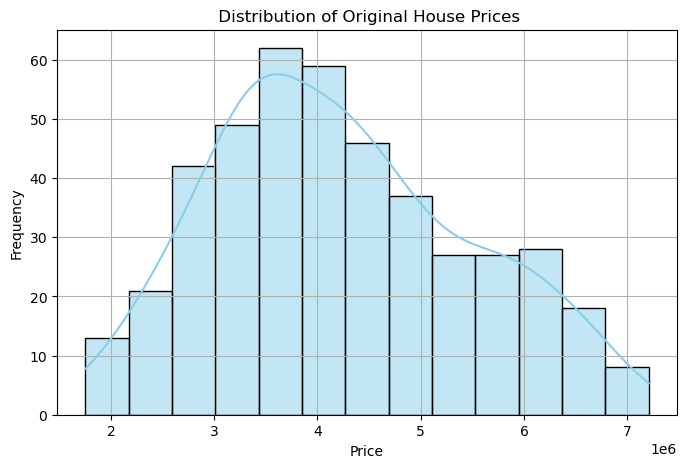

In [115]:
plt.figure(figsize=(8, 5))
sns.histplot(np.expm1(y), kde=True, color='skyblue')
plt.title(' Distribution of Original House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

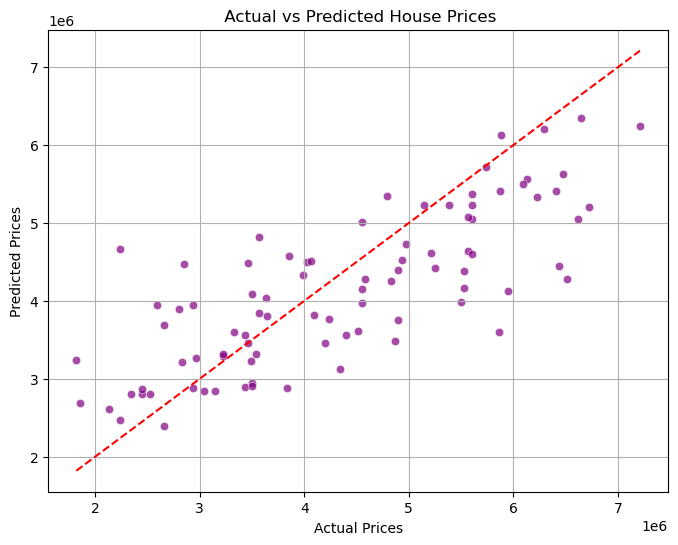

In [117]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_actual, y=y_pred, alpha=0.7, color='purple')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
plt.title(' Actual vs Predicted House Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.show()

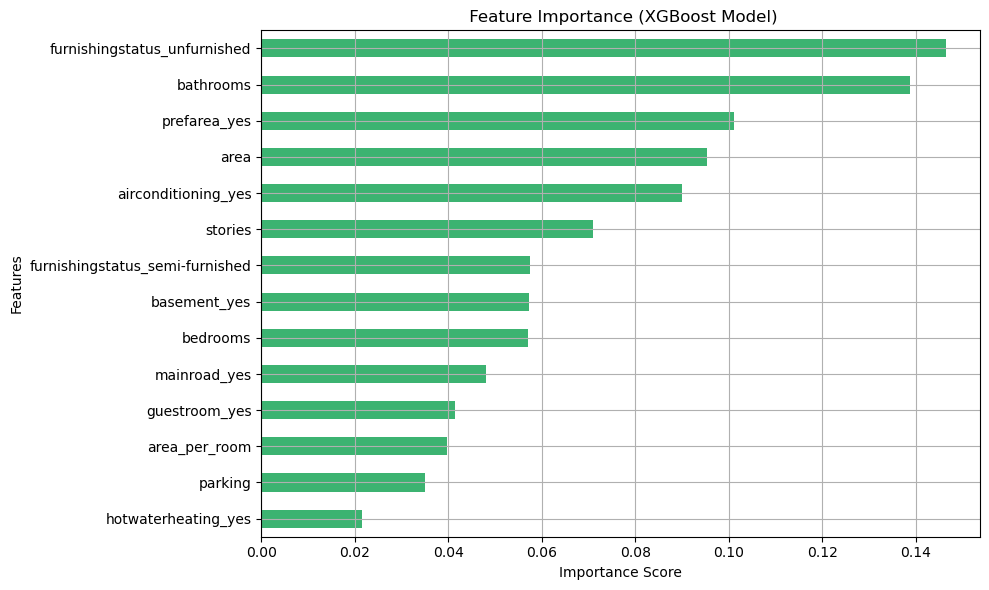

In [119]:
importances = model.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh', color='mediumseagreen')
plt.title(' Feature Importance (XGBoost Model)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True)
plt.tight_layout()
plt.show()